In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
#import pybullet_envs

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
import numpy as np
import math
import random

In [5]:
import time

In [6]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [7]:
import gym

In [8]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [9]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 1000
gamma=0.99
#gamma=0.85
egreedy = 0.9
egreedy_final = 0.0002
egreedy_decay = 50000

report_interval=10

score_to_solve = 20000

hidden_layer_size=512

In [10]:
env = gym.make('Breakout-ram-v0')
#env = gym.make('AntBulletEnv-v0')

In [11]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
env = gym.wrappers.Monitor(env, '../mp4/breakout',video_callable=lambda episode_id: episode_id%10==0,force=True)

In [12]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [13]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [15]:
class QNet_Agent():
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state)
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor([reward]).to(device)
        
        
        if done:
            target_value=reward
        else:
            self.nn.eval()
            new_state_values=self.nn(new_state).detach()
            max_new_state_values=torch.max(new_state_values)
            target_value=reward + gamma*max_new_state_values
        
        self.nn.train()
        #the view call needed to make it a tensor
        predicted_value=self.nn(state)[action].view(-1)
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        

In [16]:
qnet_agent=QNet_Agent()

In [17]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [18]:
%%time

num_episodes=1000

steps_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        
        qnet_agent.optimize(state,
                            action,
                            new_state,
                            reward,
                            done)
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(steps_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(steps_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(steps_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 223.6
Average over all episodes so far: 223.6
epsilon: 0.8540645002668565
**** Episode  20 **** 
Recent average reward: 245.0
Average over all episodes so far: 234.3
epsilon: 0.8166066010055225
**** Episode  30 **** 
Recent average reward: 245.2
Average over all episodes so far: 237.93333333333334
epsilon: 0.7775047727694918
**** Episode  40 **** 
Recent average reward: 305.0
Average over all episodes so far: 254.7
epsilon: 0.727757123623005
**** Episode  50 **** 
Recent average reward: 252.9
Average over all episodes so far: 254.34
epsilon: 0.6943114347402988
**** Episode  60 **** 
Recent average reward: 280.5
Average over all episodes so far: 258.7
epsilon: 0.6550934275764686
**** Episode  70 **** 
Recent average reward: 236.4
Average over all episodes so far: 255.5142857142857
epsilon: 0.62675246660425
**** Episode  80 **** 
Recent average reward: 217.6
Average over all episodes so far: 250.775
epsilon: 0.6003817442348037
**** Episode  9

**** Episode  550 **** 
Recent average reward: 324.7
Reward over last 100: 313.49
Average over all episodes so far: 279.11454545454546
epsilon: 0.04169083321313092
**** Episode  560 **** 
Recent average reward: 368.0
Reward over last 100: 319.97
Average over all episodes so far: 280.70178571428573
epsilon: 0.03863976675851105
**** Episode  570 **** 
Recent average reward: 344.8
Reward over last 100: 317.89
Average over all episodes so far: 281.8263157894737
epsilon: 0.03617529728544854
**** Episode  580 **** 
Recent average reward: 377.4
Reward over last 100: 320.49
Average over all episodes so far: 283.4741379310345
epsilon: 0.033577850336249396
**** Episode  590 **** 
Recent average reward: 390.5
Reward over last 100: 331.4
Average over all episodes so far: 285.2881355932203
epsilon: 0.030950077556350063
**** Episode  600 **** 
Recent average reward: 429.6
Reward over last 100: 339.11
Average over all episodes so far: 287.6933333333333
epsilon: 0.028500869156094587
**** Episode  610 

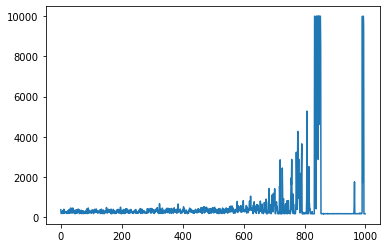

In [19]:
plt.plot(steps_total)
plt.show()

In [20]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 542.118


In [21]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average number of steps=reward in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps=reward: 542.118
Average number of steps=reward in last 100 episodes: 568.69


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

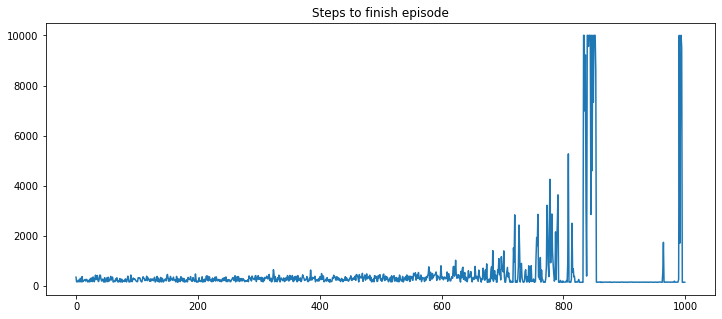

In [22]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()